### Sparse Softmax Operator
This is an example of how to create and tune a sparse softmax operator.

In [1]:
import torch
import matplotlib.pyplot as plt
import sparta

First, determine the height (batch size) and width (dimensions) of the input tensor and create a dense softmax operator.

In [2]:
H, W = 3072, 4096
dense_softmax = torch.nn.Softmax(dim=-1)

Then generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

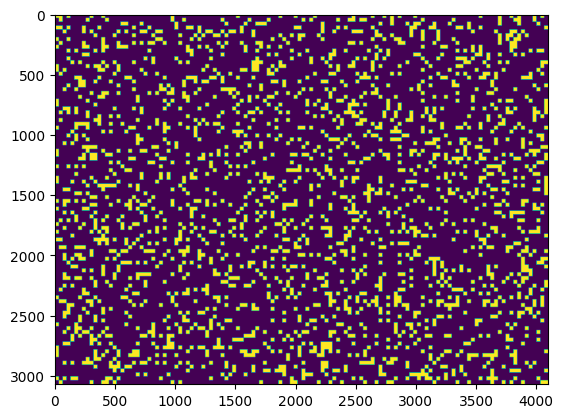

In [3]:
mask = sparta.testing.block_mask((H, W), block=(32, 32), sparsity=0.8).cuda()
plt.imshow(mask.cpu().numpy())

Create a ```sparta.nn.SparseSoftmax``` operator using the dense operator and the mask.

Next, tune the sparse operator using a sample input (to determine the shape). This step may take several minutes.

In [4]:
x = torch.rand((H, W)).cuda()
sparse_softmax = sparta.nn.SparseSoftmax(dense_softmax, mask=mask)

In [5]:
{'root': {'_name': 'sparta',
  'BLOCK_SIZE_H_VALUE': 32,
  'BLOCK_SIZE_W_VALUE': 32,
  'ROW_TILE_VALUE': 2}}

{'root': {'_name': 'sparta',
  'BLOCK_SIZE_H_VALUE': 32,
  'BLOCK_SIZE_W_VALUE': 32,
  'ROW_TILE_VALUE': 2}}

Check whether the sparse operator works correctly.

In [9]:
# sparse_softmax.set_parameter('BLOCK_SIZE_H_VALUE', 32)
# sparse_softmax.set_parameter('BLOCK_SIZE_W_VALUE', 32)
# sparse_softmax.set_parameter('ROW_TILE_VALUE', 2)
sparse_softmax.build({'_name': 'sparta',
  'BLOCK_SIZE_H_VALUE': 32,
  'BLOCK_SIZE_W_VALUE': 32,
  'ROW_TILE_VALUE': 2}, sample_inputs=[mask])

In [11]:
import sparta.specializer.kernels.softmax as sparta_softmax
sparse_softmax_kernel = sparta_softmax.SparTATemplateSparseSoftmaxKernel()


In [12]:
sparse_softmax_kernel.set_parameters({'_name': 'sparta', 'H': 3072, 'W': 4096, 'BLOCK_SIZE_H_VALUE': 32, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 2})

In [14]:
print(sparse_softmax_kernel.get_kernel_code())





#define FULL_MASK 0xffffffff


const int H = None;
const int W = None;
const int block_h = 32;
const int block_w = 32;
const int row_tile = 2;

__global__ void SPARSE_SOFTMAX(
    float* in_val,
    int* row_ptr,
    int* col_idx,
    int* mask,
    float* out_val
) {
    int num_nnz = row_ptr[H / block_h];
    in_val += blockIdx.y * num_nnz * block_h * block_w;

    uint blk_row_idx = blockIdx.x / (block_h/row_tile) ;
    int block_inter_row = (blockIdx.x % (block_h/row_tile)) * row_tile;
    uint bm = threadIdx.x / 32;
    uint bn = threadIdx.x % 32;
    float regC = 0.0f;
    float regSum = 0.0f;
    float regMax = -100000.0;
    int block_seq_start = row_ptr[blk_row_idx];
    int block_seq_end = row_ptr[blk_row_idx+1];

    uint index_list[W / 32];
    int val_num = 0;
    for (int block_inter_col = bn; block_inter_col < block_w; block_inter_col += 32) {
        for (int block_seq = block_seq_start; block_seq < block_seq_end; block_seq++) {
            
            uint index =

In [ ]:
torch.testing.assert_close(
    sparse_softmax(x),
    sparta.testing.sparse_softmax_reference(x, mask)
)

The sparse softmax operator is ready to use. Let's compare it with the dense operator.

In [ ]:
dense_latency = sparta.testing.test_latency(dense_softmax, inputs=[x])
print(f'Dense linear operator latency: {dense_latency} ms')
sparse_latency = sparta.testing.test_latency(sparse_softmax, inputs=[x])
print(f'Sparse linear operator latency: {sparse_latency} ms')